In [1]:
## Créer un récapitulatif des statistiques mensuelles sur l'appli vigilo 

In [1]:
# Importer les packqges nécéssaires

import datetime
import locale
import textwrap

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import overpy
import geopy.distance

# Setting french locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

PLOT_VIGILO_RELEASE_DATE = True
PLOT_VIGILO_PRESS_CONFERENCE_DATE = True

sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.8)
blue, orange = sns.color_palette("muted", 2)

In [2]:
# Obtenir les données

resp = requests.get('https://vigilo.bapav.org/get_issues.php')
df = pd.DataFrame(resp.json())
df = df[df.comment != '']
df.time = pd.to_datetime(df.time, unit='s')
df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)

# Filtering out data before 2019-01-01
df = df[df.time.apply(lambda x: x.year) > 2021]
df = df.sort_values(by='time', ascending=True)
df = df.reset_index(drop=True)

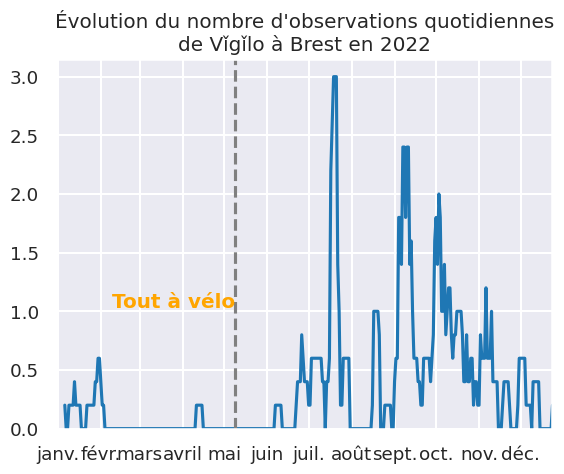

In [3]:
# Afficher l'évolution du nombre d'obs quotidiennes 

fig, ax = plt.subplots()

WINDOWS_SIZE = 5  # Smoothing window in days
count = df.groupby('julian_day').token.count()
count = pd.Series([count[x] if x in count.index else 0 for x in range(df.julian_day.min(), df.julian_day.max() + 1)],
                  range(df.julian_day.min(), df.julian_day.max() + 1))

count_smoothed = count.rolling(WINDOWS_SIZE).sum().apply(lambda x: x / WINDOWS_SIZE)

ax.plot(count_smoothed)

ticks = [datetime.datetime(year=2022, month=x, day=1).timetuple().tm_yday for x in range(1, 13)]
ticks_labels = [datetime.datetime(year=2022, month=x, day=1).strftime('%b') for x in range(1, 13)]
plt.xticks(ticks, ticks_labels)
ax.set_xlim(0, count_smoothed.dropna().index.max())

ylim = ax.get_ylim()
if PLOT_VIGILO_RELEASE_DATE:
    vigilo_release_date = datetime.datetime(year=2022, month=5, day=9).timetuple().tm_yday
    ax.plot((vigilo_release_date, vigilo_release_date), (0, 10), '--', color='grey')
    ax.text(x=vigilo_release_date,
            y=1,
            s='Tout à vélo',
            horizontalalignment='right',
            verticalalignment='bottom',
            color='orange',
            fontweight='bold')
ax.set_ylim(0, ylim[1])

plt.title("Évolution du nombre d'observations quotidiennes\nde Vǐgǐlo à Brest en 2022")

plt.show()

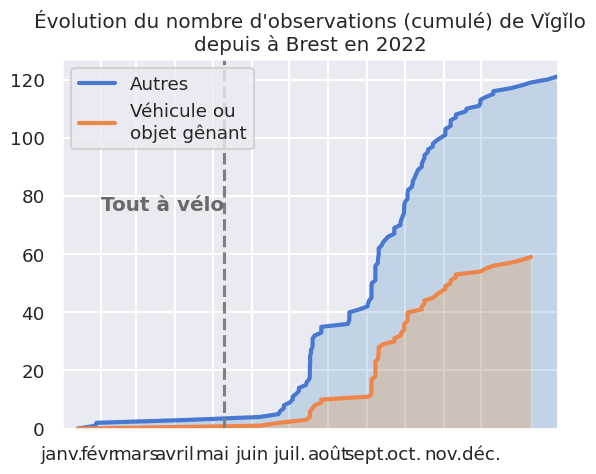

In [4]:
# Afficher l'évolution du nombre d'observation depuis le premier janvier

fig, ax = plt.subplots()

x1 = df.time
y1 = df.index
ax.plot(x1, y1, color=blue, lw=3, label='Autres')
ax.fill_between(x1, 0, y1, alpha=.2)

df2 = df[df.categorie == '2']
df2 = df2.reset_index(drop=True)

x2 = df2.time[df2.categorie == '2']
y2 = df2.index[df2.categorie == '2']
ax.plot(x2, y2, color=orange, lw=3, label='Véhicule ou\nobjet gênant')
ax.fill_between(x2, 0, y2, alpha=.2)

ticks = [datetime.datetime(year=2022, month=x, day=1) for x in range(1, 13)]
ticks_labels = [x.strftime('%h') for x in ticks]
#plt.xticks(ticks, ticks_labels)
#ticks = [datetime.datetime(year=2019, month=x, day=1).timetuple().tm_yday for x in range(1, 13)]
#ticks_labels = [datetime.datetime(year=2019, month=x, day=1).strftime('%b') for x in range(1, 13)]
plt.xticks(ticks, ticks_labels)
ax.set_xlim(0, count_smoothed.dropna().index.max())
plt.gca().legend()

#ticks = [datetime.datetime(year=2019, month=x, day=1) for x in range(1, 13)]
#ticks_labels = [x.strftime('%b') for x in ticks]
#plt.xticks(ticks, ticks_labels)

ylim = ax.get_ylim()

if PLOT_VIGILO_RELEASE_DATE:
    vigilo_release_date = datetime.datetime(year=2022, month=5, day=10)
    ax.plot((vigilo_release_date, vigilo_release_date), (0, 1000000), '--', color='grey')
    ax.text(x=vigilo_release_date,
            y=80,
            s='Tout à vélo',
            horizontalalignment='right',
            verticalalignment='top',
            color='dimgrey',
            fontweight='bold')

if 0:
    vigilo_release_date = datetime.datetime(year=2022, month=4, day=16)
    ax.plot((vigilo_release_date, vigilo_release_date), (0, 1000000), '--', color='grey')
    ax.text(x=vigilo_release_date,
            y=50,
            s='Conférence de presse  ',
            horizontalalignment='right',
            verticalalignment='top',
            color='dimgrey',
            fontweight='bold')

ax.set_xlim(datetime.date(year=2022, month=1, day=1), max(x1) + datetime.timedelta(days=1))
ax.set_ylim(0, ylim[1])

plt.title("Évolution du nombre d'observations (cumulé) de Vǐgǐlo\ndepuis à Brest en 2022")

plt.show()

In [51]:
BUFFER_SIZE = 300  # Max distance between schools and GCUM (m)
# Getting GCUM data
resp = requests.get('https://vigilo.bapav.org/get_issues.php?c=2')
gcum = resp.json()
# Getting schools
api = overpy.Overpass()
bbox = '48.377, -4.546, 48.416, -4.431'
query = """(
  node["school:FR"="maternelle"]({bbox});
  way["school:FR"="maternelle"]({bbox});
  node["school:FR"="élémentaire"]({bbox});
  way["school:FR"="élémentaire"]({bbox});
  node["school:FR"="primaire"]({bbox});
  way["school:FR"="primaire"]({bbox});
  );
  out center;""".format(bbox=bbox)

result = api.query(query)

# Mettre la valeur "none" dans les écoles sans tags['name']
for x in result.ways:
    x.tags.setdefault('name','Pas de nom renseigné, coos gps: ('+str(x.center_lat)+','+str(x.center_lon)+')')   


schools = [{'name': x.tags['name'], 'lat': x.lat, 'lon': x.lon} for x in result.nodes] + \
          [{'name': x.tags['name'], 'lat': x.center_lat, 'lon': x.center_lon} for x in result.ways]


# Filtering gcum on day and time
week_gcum = [x for x in gcum
             if datetime.datetime.fromtimestamp(int(x['time'])).weekday() < 4
             and (datetime.time(hour=7, minute=30) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=9)
                  or datetime.time(hour=16) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=17, minute=30))]
# Counting GCUM within X meters of each school
for school in schools:
    school['gcum'] = [x for x in week_gcum if geopy.distance.great_circle((x['coordinates_lat'], x['coordinates_lon']),
                                                                     (school['lat'],
                                                                      school['lon'])).meters < BUFFER_SIZE]
    school['nb_gcum'] = len(school['gcum'])

schools.sort(key=lambda x: len(x['gcum']), reverse=True)

print("Classement des écoles de Brest par nombre de GCUM à proximité (moins de {} m) \n".format(BUFFER_SIZE))
print('\n'.join(['{} - {}'.format(x['nb_gcum'], x['name']) for x in schools if x['nb_gcum'] != 0]))

Classement des écoles de Brest par nombre de GCUM à proximité (moins de 300 m) 

5 - École primaire publique La Pointe
5 - École Javouhey
4 - Skol Diwan Brest (Kerango)
2 - École maternelle publique République-Sanquer
2 - École primaire privée Immaculée Conception
1 - École primaire privée de la Providence
1 - École primaire du Petit Paris
1 - École primaire du Petit Paris
1 - Pas de nom renseigné, coos gps: (48.3863738,-4.4859900)
1 - École primaire privée Saint-Louis
1 - Pas de nom renseigné, coos gps: (48.3848874,-4.4916573)
1 - Pas de nom renseigné, coos gps: (48.3850413,-4.4911242)
1 - Pas de nom renseigné, coos gps: (48.3863855,-4.4867933)
1 - École primaire publique Jean Macé
1 - École élémentaire publique Vauban
1 - École maternelle publique Vauban
1 - École Sainte-Marie
1 - École élémentaire publique Jacques Kerhoas
1 - École maternelle publique Jacques Kerhoas


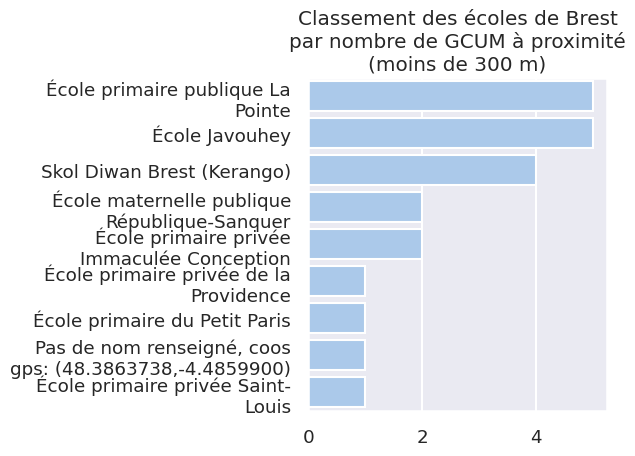

In [52]:
sns.set_color_codes("pastel")
sns.barplot(x=[x['nb_gcum'] for x in schools[:10]],
            y=['\n'.join(textwrap.wrap(x['name'], 30)) for x in schools[:10]],
            color="b")

plt.title("Classement des écoles de Brest\npar nombre de GCUM à proximité\n(moins de {} m)".format(BUFFER_SIZE))

plt.tight_layout()
plt.show()

0 Text(0, 0, 'Non')
1 Text(0, 0, 'Oui')


/tmp/ipykernel_8052/144163298.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.pie(x=(df[df.hour == 'Journée et weekend'][df.school == 'Non'].token.count(),
/tmp/ipykernel_8052/144163298.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.hour == 'Journée et weekend'][df.school == 'Oui'].token.count()),
/tmp/ipykernel_8052/144163298.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.pie(x=(df[df.hour == "Horaires d'école"][df.school == 'Non'].token.count(),
/tmp/ipykernel_8052/144163298.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.hour == "Horaires d'école"][df.school == 'Oui'].token.count()),


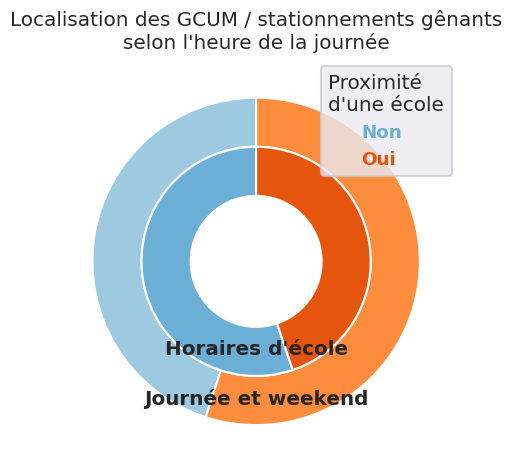

In [59]:
df = pd.DataFrame(gcum)
df.time = pd.to_datetime(df.time, unit='s')
df['hour'] = 'Journée et weekend'
df.loc[df.token.apply(lambda x: x in [y['token'] for y in week_gcum]), 'hour'] = "Horaires d'école"

# Separating obs near schools
df["school"] = 'Non'

for school in schools:
    df.loc[df.apply(lambda row: geopy.distance.great_circle((row['coordinates_lat'], row['coordinates_lon']),
                                                            (school['lat'],
                                                             school['lon'])).meters < BUFFER_SIZE,
                    axis=1), "school"] = 'Oui'
fig, ax = plt.subplots(figsize=(5, 5))

size = 0.3
cmap = plt.get_cmap("tab20c")
outer_colors = cmap([2, 5])
inner_colors = cmap([1, 4])

ax.pie(x=(df[df.hour == 'Journée et weekend'][df.school == 'Non'].token.count(),
          df[df.hour == 'Journée et weekend'][df.school == 'Oui'].token.count()),
       radius=1,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       colors=outer_colors)
ax.pie(x=(df[df.hour == "Horaires d'école"][df.school == 'Non'].token.count(),
          df[df.hour == "Horaires d'école"][df.school == 'Oui'].token.count()),
       radius=1 - size,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       colors=inner_colors)

plt.title("Localisation des GCUM / stationnements gênants\nselon l'heure de la journée")

ax.annotate("Horaires d'école",
            xy=(0.5, 0.31),
            xycoords='axes fraction',
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='center')

ax.annotate("Journée et weekend",
            xy=(0.5, 0.19),
            xycoords='axes fraction',
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='center')

legend = ax.legend(title="Proximité\nd'une école", labels=("Non", "Oui"), handlelength=0, handletextpad=-0.5)

for n, text in enumerate(legend.texts):
    print(n, text)
    text.set_color(inner_colors[n])
    text.set_fontweight('bold')

plt.tight_layout()

plt.show()   

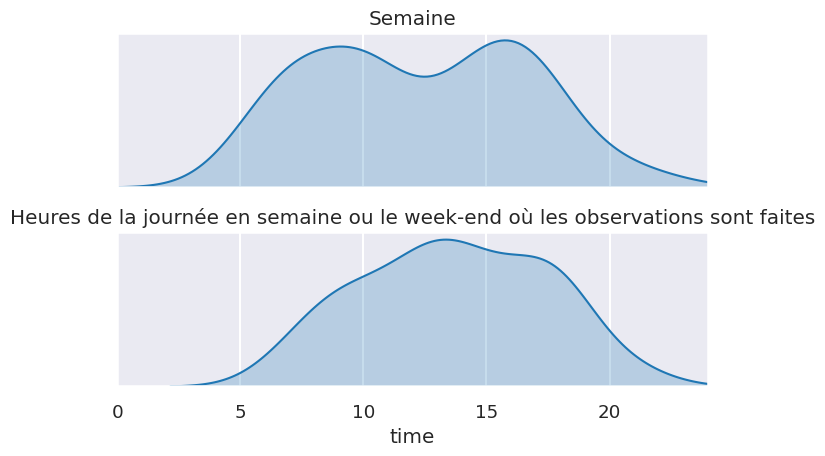

In [70]:
# Afficher les heures des observations
# Separating week days and weekends
df.time = pd.to_datetime(df.time, unit='s')
df['day_type'] = 'week'
df.loc[df.time.apply(lambda x: x.weekday() > 4), 'day_type'] = 'weekend'
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

sns.kdeplot(df[(df.categorie == '2') & (df.day_type == 'week')].time.apply(lambda x: x.hour),
            fill=True, legend='GCUM', label='GCUM', ax=ax1)
sns.kdeplot(df[(df.categorie != '2') & (df.day_type == 'week')].time.apply(lambda x: x.hour),
            fill=True, label='Autres', ax=ax1)
# sns.kdeplot(df[df.day_type == 'week'].time.apply(lambda x: x.hour),
#             shade=True, label='Total', ax=ax1)
sns.kdeplot(df[(df.categorie == '2') & (df.day_type == 'weekend')].time.apply(lambda x: x.hour),
            fill=True, legend='GCUM', label='GCUM', ax=ax2)
sns.kdeplot(df[(df.categorie != '2') & (df.day_type == 'weekend')].time.apply(lambda x: x.hour),
            fill=True, label='Autres', ax=ax2)
# sns.kdeplot(df[df.day_type == 'weekend'].time.apply(lambda x: x.hour),
#             shade=True, label='Total', ax=ax2)



ax1.set_title('Semaine')
ax2.set_title('Weekend')

ax1.set_xbound(0, 24)

ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)



plt.tight_layout()

plt.title("Heures de la journée en semaine ou le week-end où les observations sont faites")
plt.show()

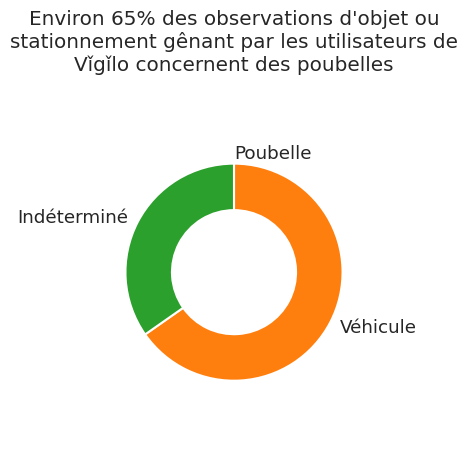

In [64]:
# Types de observations stationnement genants

total = len(df)

poubelles = df[df.comment.str.lower().str.match(r'.*(poubelle|conteneur).*')]
df = df[~df.token.isin(poubelles.token)]

vehicules = df[df.comment.str.lower().str.match(r'.*(voiture|station|garé|gare|gcum|parking|'
                                                r'moto|scooter|véhicule|utilitaire|camion|pv).*')]
autres = df[~df.token.isin(vehicules.token)]
fig, ax = plt.subplots(figsize=(5, 5))
size = 0.3
min_proportion = 0.04
cmap = plt.get_cmap("tab20c")
ax.pie(x=[len(poubelles), len(vehicules), len(autres)],
       radius=1 - size,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       labels=['Poubelle', 'Véhicule', 'Indéterminé'],
       labeldistance=1.1,
       counterclock=False,
       pctdistance=0.8)

title = '\n'.join(textwrap.wrap("Environ {0:.0%} des observations d'objet ou stationnement "
                                "gênant par les utilisateurs de Vǐgǐlo concernent des poubelles".format(
    len(vehicules) / total), 50))
plt.title(title)

plt.tight_layout()
plt.show()